In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# load data
df = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv',
                 parse_dates = ['Month'], 
                 index_col = ['Month'])\
       .rename(columns={'#Passengers':'Passengers'})

Print top 5 rows

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Create function **plot_timeseries(df)**

In [4]:
def plot_timeseries(df):
    plt.plot(df.index,df.values)
    plt.show()

Plot the timeseries from above

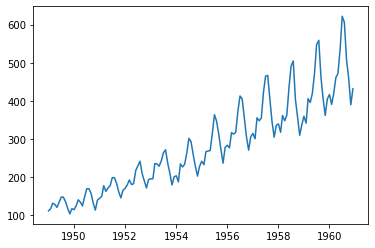

In [5]:
plot_timeseries(df)

Compute a rolling mean and a rolling std with an appropriate window size

In [12]:
import pandas as pd

width = 6
#lag1 = df.shift(1)
#lag3 = df.shift(width - 1)
window = df.rolling(window=width)
means = window.mean()
std = window.std()
dataframe = pd.concat([means, std, df], axis=1)
dataframe.columns = ['mean', 'std', 'actual']
print(dataframe.head(10))

mean        std  actual
Month                                    
1949-01-01         NaN        NaN     112
1949-02-01         NaN        NaN     118
1949-03-01         NaN        NaN     132
1949-04-01         NaN        NaN     129
1949-05-01         NaN        NaN     121
1949-06-01  124.500000   8.916277     135
1949-07-01  130.500000  10.747093     148
1949-08-01  135.500000  10.747093     148
1949-09-01  136.166667  10.609744     136
1949-10-01  134.500000  12.565827     119


In [43]:
dataframe.tail()

,mean,std,actual
Month,,,
1960-08-01,519.166667,82.470399,606
1960-09-01,534.000000,67.495185,508
1960-10-01,534.000000,67.495185,461
1960-11-01,520.333333,87.805846,390
1960-12-01,503.166667,94.200672,432


Plot two timeseries:
- with rolling mean 
- with rolling std

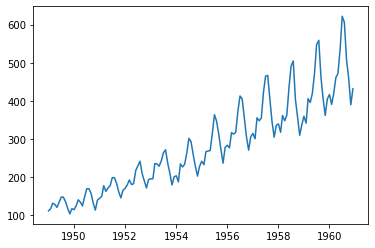

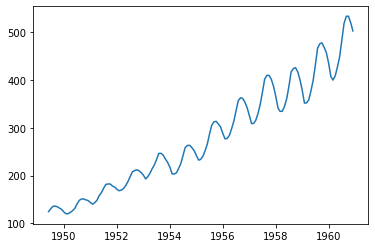

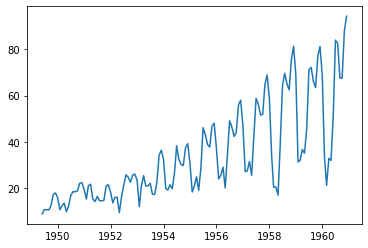

In [13]:
plot_timeseries(dataframe.actual)
plot_timeseries(dataframe['mean'])
plot_timeseries(dataframe['std'])

Test the stationarity of all timeseries

In [16]:
from statsmodels.tsa.stattools import adfuller

def ADF_Stationarity_Test(timeseries, significance_level=0.05):
    result = adfuller(timeseries)
    p = result[1]
    print('p-value: ', p)
    if p>significance_level:
        print('Reject H0, the time series is non-stationary')
    else:
        print('Cannot reject H0, the time series may be stationary')

In [18]:
ADF_Stationarity_Test(dataframe.actual,0.05)
ADF_Stationarity_Test(dataframe['mean'][5:],0.05)
ADF_Stationarity_Test(dataframe['std'][5:],0.05)

p-value:  0.9918802434376409
Reject H0, the time series is non-stationary
p-value:  0.9938898364147177
Reject H0, the time series is non-stationary
p-value:  0.9943421724187669
Reject H0, the time series is non-stationary


Transform the original timeseries with logarithm

In [19]:
import numpy as np
df_log = np.log(dataframe.actual)

Plot transformed timeseries

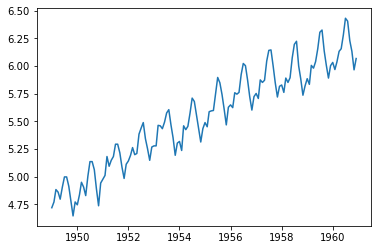

In [20]:
plot_timeseries(df_log)

Test the stationarity of transformed timeseries. If it isn't stationary, try different transformation techniques

In [21]:
ADF_Stationarity_Test(df_log)

p-value:  0.4223667747703857
Reject H0, the time series is non-stationary


In [47]:
dataframe.actual[:len(dataframe)-12].isna().sum()

0

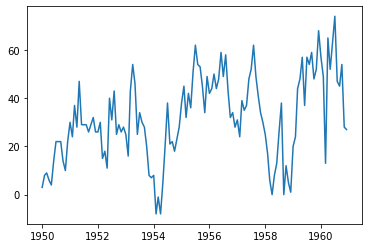

p-value:  0.011551493085514982
Cannot reject H0, the time series may be stationary


In [54]:
#df_s = dataframe.actual-dataframe.actual.ewm(halflife=6).mean()
df_s = dataframe.actual[12:]-dataframe.actual[:len(dataframe)-12].values
plot_timeseries(df_s)
ADF_Stationarity_Test(df_s)

Use the stationary TS and find the optimal (p,d,q) params of ARIMA model

In [55]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_s, p_values, d_values, q_values)

Plot the predictions (not transformed to the original scale)

Plot the predictions (transformed to the original scale)

Plot the predictions for the next 10 years